In [11]:
import numpy as np

# Set numpy to print all elements
np.set_printoptions(threshold=np.inf)

# Load and print the strokes file
strokes = np.load('styles/style-10-strokes.npy')
print("Strokes Array:")
print(strokes)

# Load the chars file and print the raw numpy array
chars_array = np.load('styles/style-10-chars.npy')
print("Chars Array (raw):")
print(chars_array)

# If the chars file is stored as bytes, convert it to a string to see the content
chars_string = chars_array.tobytes().decode('utf-8')
print("Decoded Chars String:")
print(chars_string)


Strokes Array:
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-7.58371306e-01  1.92704676e-01  0.00000000e+00]
 [-1.14849736e+00  3.57324424e-01  0.00000000e+00]
 [-1.41366017e+00  4.66816496e-01  0.00000000e+00]
 [-1.35782303e+00  5.76528745e-01  0.00000000e+00]
 [-1.17604407e+00  2.94837909e-01  0.00000000e+00]
 [-1.09548828e+00  1.47584333e+00  0.00000000e+00]
 [-8.70789298e-01  2.20519028e+00  0.00000000e+00]
 [-4.80144604e-01  2.34633905e+00  0.00000000e+00]
 [-2.14756725e-01  1.91581768e+00  0.00000000e+00]
 [-8.27673554e-02  1.08139200e+00  0.00000000e+00]
 [ 4.14737060e-01 -4.11292498e-02  0.00000000e+00]
 [ 6.26597221e-01  3.20696591e-01  0.00000000e+00]
 [ 8.03913901e-01  1.30526409e-01  0.00000000e+00]
 [ 9.69683469e-01 -1.36642465e-01  0.00000000e+00]
 [ 7.55631313e-01 -4.52720211e-01  0.00000000e+00]
 [ 4.07045509e-01 -5.15402440e-01  0.00000000e+00]
 [ 9.10988908e-01 -1.45417781e+00  0.00000000e+00]
 [ 1.13059933e+00 -1.88690097e+00  0.00000000e+00]
 [ 1.05434925e+0

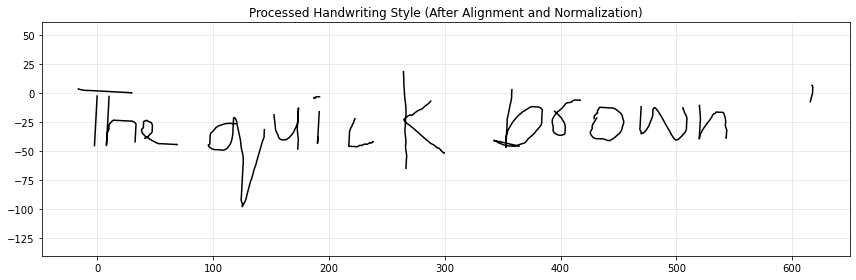

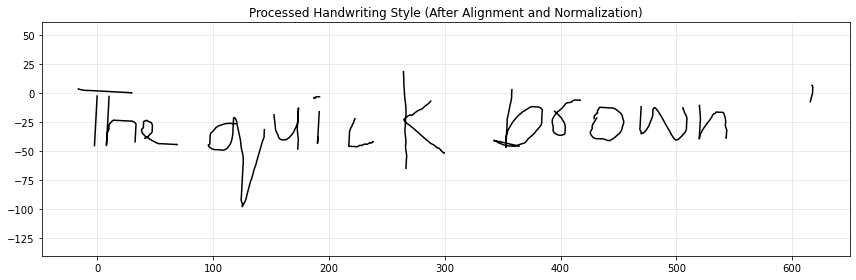

In [4]:
import tkinter as tk
from tkinter import simpledialog, messagebox
import numpy as np
import os
import matplotlib.pyplot as plt
import drawing


class HandwritingRecorder:
    def __init__(self, master):
        self.master = master
        master.title("Handwriting Style Recorder")

        # Create a drawing canvas
        self.canvas = tk.Canvas(master, width=1600, height=600, bg="white")
        self.canvas.pack(padx=20, pady=20)

        # Bind mouse events to record strokes
        self.canvas.bind("<ButtonPress-1>", self.start_stroke)
        self.canvas.bind("<B1-Motion>", self.draw)
        self.canvas.bind("<ButtonRelease-1>", self.end_stroke)

        # List to hold all strokes; each stroke is a list of (x, y) tuples
        self.strokes = []
        # Stack for redo functionality
        self.redo_stack = []
        self.current_stroke = []

        # Create a text field for priming text
        self.label = tk.Label(master, text="Enter priming text for your style:", font=("Helvetica", 16))
        self.label.pack()
        self.text_entry = tk.Entry(master, width=80, font=("Helvetica", 16))
        self.text_entry.pack(pady=(0, 20))

        # Create a frame for buttons
        self.button_frame = tk.Frame(master)
        self.button_frame.pack(pady=20)

        # Create buttons
        self.save_button = tk.Button(self.button_frame, text="Save Style", command=self.save_style,
                                     font=("Helvetica", 16), width=15, height=2)
        self.save_button.grid(row=0, column=0, padx=10)

        self.clear_button = tk.Button(self.button_frame, text="Clear Canvas", command=self.clear_canvas,
                                      font=("Helvetica", 16), width=15, height=2)
        self.clear_button.grid(row=0, column=1, padx=10)

        self.undo_button = tk.Button(self.button_frame, text="Undo", command=self.undo_stroke,
                                     font=("Helvetica", 16), width=15, height=2)
        self.undo_button.grid(row=0, column=2, padx=10)

        self.redo_button = tk.Button(self.button_frame, text="Redo", command=self.redo_stroke,
                                     font=("Helvetica", 16), width=15, height=2)
        self.redo_button.grid(row=0, column=3, padx=10)
        
        self.preview_button = tk.Button(self.button_frame, text="Preview Style", command=self.preview_style,
                                       font=("Helvetica", 16), width=15, height=2)
        self.preview_button.grid(row=0, column=4, padx=10)

    def start_stroke(self, event):
        # Start a new stroke
        self.current_stroke = [(event.x, event.y)]

    def draw(self, event):
        # Append point to current stroke and draw a line segment
        x, y = event.x, event.y
        self.current_stroke.append((x, y))
        if len(self.current_stroke) > 1:
            x1, y1 = self.current_stroke[-2]
            self.canvas.create_line(x1, y1, x, y, fill="black", width=3)

    def end_stroke(self, event):
        # Save the current stroke when the mouse is released
        if self.current_stroke and len(self.current_stroke) > 1:  # Only save strokes with multiple points
            self.strokes.append(self.current_stroke)
            # Clear the redo stack since new action invalidates redo history
            self.redo_stack = []
            self.current_stroke = []

    def clear_canvas(self):
        # Clear the canvas and reset strokes and redo history
        self.canvas.delete("all")
        self.strokes = []
        self.redo_stack = []

    def redraw_canvas(self):
        # Redraw all strokes from self.strokes
        self.canvas.delete("all")
        for stroke in self.strokes:
            if len(stroke) < 2:
                continue
            for i in range(1, len(stroke)):
                x1, y1 = stroke[i-1]
                x2, y2 = stroke[i]
                self.canvas.create_line(x1, y1, x2, y2, fill="black", width=3)

    def undo_stroke(self):
        # Remove the last stroke and push it to redo stack
        if self.strokes:
            stroke = self.strokes.pop()
            self.redo_stack.append(stroke)
            self.redraw_canvas()

    def redo_stroke(self):
        # Re-add the last undone stroke
        if self.redo_stack:
            stroke = self.redo_stack.pop()
            self.strokes.append(stroke)
            self.redraw_canvas()

    def convert_strokes_to_offsets(self):
        """
        Convert the recorded strokes (absolute coordinates) to offsets, following
        the exact same pipeline as in the model's training data preprocessing.
        """
        if not self.strokes:
            return None
            
        # Convert to the format expected by the model's preprocessing pipeline
        coords = []
        for stroke in self.strokes:
            if len(stroke) < 2:
                continue
                
            # Process points in the stroke
            for i, (x, y) in enumerate(stroke):
                # CRITICAL CHANGE: Negate y-coordinates to match the model's convention
                # The model expects y to increase upward, but in canvas y increases downward
                eos = 1.0 if i == len(stroke) - 1 else 0.0
                coords.append([x, -y, eos])  # Note the -y here
                
        if not coords:
            return None
            
        # Convert to numpy array
        coords = np.array(coords, dtype=np.float32)
        
        # Apply the model's preprocessing pipeline
        # Step 1: Align the coordinates (correct slant and offset)
        coords = drawing.align(coords)
        
        # Step 2: Denoise the coordinates (smooth out jitter)
        coords = drawing.denoise(coords)
        
        # Step 3: Convert to relative offsets
        offsets = drawing.coords_to_offsets(coords)
        
        # Step 4: Clip to maximum stroke length
        if hasattr(drawing, 'MAX_STROKE_LEN'):
            offsets = offsets[:drawing.MAX_STROKE_LEN]
        else:
            offsets = offsets[:1200]  # Default max length from the model
            
        # Step 5: Normalize the offsets
        offsets = drawing.normalize(offsets)
        
        return offsets

    def preview_style(self):
        """Preview the processed style to verify it looks correct"""
        if not self.strokes:
            messagebox.showerror("Error", "No strokes recorded on the canvas!")
            return
            
        # Process the strokes
        offsets = self.convert_strokes_to_offsets()
        if offsets is None:
            messagebox.showerror("Error", "Could not process the strokes!")
            return
            
        # Convert offsets back to coordinates for visualization
        coords = drawing.offsets_to_coords(offsets)
        
        # Create a new figure window
        plt.figure(figsize=(12, 4))
        
        # Plot the processed strokes
        stroke = []
        for x, y, eos in coords:
            stroke.append((x, y))
            if eos == 1:
                x_vals, y_vals = zip(*stroke)
                plt.plot(x_vals, y_vals, 'k')
                stroke = []
                
        if stroke:  # In case the last stroke doesn't end with eos=1
            x_vals, y_vals = zip(*stroke)
            plt.plot(x_vals, y_vals, 'k')
            
        plt.title("Processed Handwriting Style (After Alignment and Normalization)")
        plt.axis('equal')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def save_style(self):
        # Get the priming text
        text = self.text_entry.get().strip()
        if not text:
            messagebox.showerror("Error", "Please enter priming text.")
            return
        if not self.strokes:
            messagebox.showerror("Error", "No strokes recorded on the canvas!")
            return

        # Convert strokes to offset data
        offsets = self.convert_strokes_to_offsets()
        if offsets is None:
            messagebox.showerror("Error", "Could not process the strokes!")
            return

        # Ask for a style identifier
        style_id = simpledialog.askstring("Style Identifier", "Enter a style identifier (e.g., 9, 10):")
        if style_id is None or not style_id.strip():
            return
            
        try:
            style_id = int(style_id.strip())
        except ValueError:
            messagebox.showerror("Error", "Style identifier must be a number.")
            return

        # Create the 'styles' directory if it doesn't exist
        if not os.path.exists("styles"):
            os.makedirs("styles")

        # Save the offsets and priming text as .npy files
        strokes_filename = os.path.join("styles", f"style-{style_id}-strokes.npy")
        text_filename = os.path.join("styles", f"style-{style_id}-chars.npy")

        # Check if files already exist
        if os.path.exists(strokes_filename) or os.path.exists(text_filename):
            overwrite = messagebox.askyesno("Warning", f"Style {style_id} already exists. Overwrite?")
            if not overwrite:
                return

        # Save the stroke data
        np.save(strokes_filename, offsets)
        
        # Save the text exactly as expected by the model
        np.save(text_filename, np.array(text.encode("utf-8")))

        messagebox.showinfo("Saved", f"Style {style_id} saved successfully!")
        
        # Offer to preview the saved style
        preview = messagebox.askyesno("Preview", "Would you like to preview the saved style?")
        if preview:
            self.preview_style()

if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("1800x800")  # Set an initial window size
    app = HandwritingRecorder(root)
    root.mainloop()

In [1]:
from demo import Hand
hand = Hand()

/home/nouman/anaconda3/envs/handwriting-synthesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nouman/anaconda3/envs/handwriting-synthesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nouman/anaconda3/envs/handwriting-synthesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

INFO:tensorflow:Restoring parameters from checkpoints/model-17900


Restoring parameters from checkpoints/model-17900


In [9]:
lines = [
    "Document Title",
    "Introduction",
    "Markdown is a lightweight markup language that allows you to format text",
    "quickly and easily. It's widely used for documentation, blogging, and",
    "note-taking.",
    "Key Features",
    "Simplicity: Easy to learn and use.",
    "Flexibility: Supports various text styles and formats.",
    "Portability: Works across different platforms and applications.",
    "Additional Elements",
    "Links: Easily add hyperlinks to reference additional information.",
    "Emphasis: Use italic or bold text to highlight key points.",
    "Lists: Organize content with both bullet and numbered lists.",
    "Blockquotes: Use blockquotes to emphasize important information.",
    "Images: Include visuals with descriptive alt text.",
    "Use Cases",
    "Documentation: Ideal for writing project READMEs and guides.",
    "Blogging: Create clean and attractive posts.",
    "Notes: Organize thoughts and ideas efficiently.",
    "Conclusion",
    "Markdown offers a powerful yet simple way to format content,",
    "making it a favorite among developers, writers, and professionals alike."
]

# Set biases as desired.
biases = [.75 for _ in lines]

# Pass the style identifier (10) for each line.
styles = [5 for _ in lines]

# Create an instance of Hand and generate the SVG.
hand.write(
    filename='img/my_style_output.svg',
    lines=lines,
    biases=biases,
    styles=styles
)
